<a href="https://colab.research.google.com/github/shivupoojar/scaling-sdp/blob/main/Azure_Traces_spikes_workload.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/azurefunctions-dataset2019


/content
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/azurefunctions-dataset2019


In [55]:
!ls

app_memory_percentiles.anon.d01.csv
app_memory_percentiles.anon.d02.csv
app_memory_percentiles.anon.d03.csv
app_memory_percentiles.anon.d04.csv
app_memory_percentiles.anon.d05.csv
app_memory_percentiles.anon.d06.csv
app_memory_percentiles.anon.d07.csv
app_memory_percentiles.anon.d08.csv
app_memory_percentiles.anon.d09.csv
app_memory_percentiles.anon.d10.csv
app_memory_percentiles.anon.d11.csv
app_memory_percentiles.anon.d12.csv
fluctuating1.csv
fluctuating2.csv
fluctuating.csv
function_durations_percentiles.anon.d01.csv
function_durations_percentiles.anon.d02.csv
function_durations_percentiles.anon.d03.csv
function_durations_percentiles.anon.d04.csv
function_durations_percentiles.anon.d05.csv
function_durations_percentiles.anon.d06.csv
function_durations_percentiles.anon.d07.csv
function_durations_percentiles.anon.d08.csv
function_durations_percentiles.anon.d09.csv
function_durations_percentiles.anon.d10.csv
function_durations_percentiles.anon.d11.csv
function_durations_percentiles.ano

In [56]:
import pandas as pd
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import io
import glob
import os

In [57]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [58]:
# jump1.csv, jump.csv
df = pd.read_csv('steady1.csv')


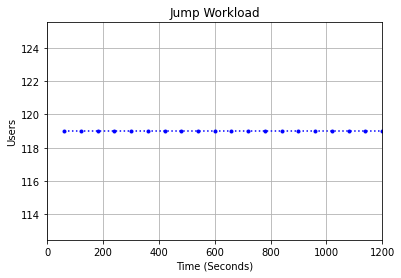

In [59]:
plt.plot(df['Time'],df['InvocationsPerMinute'],linestyle='dotted', color='b', marker='.',label='cpu_used')
#plt.plot(df['InvocationsPerMinute'], df['Time'], linestyle='dotted',  color='r', marker='.',label='cpu_requested')
plt.title('Jump Workload')
plt.xlabel('Time (Seconds)')
plt.ylabel('Users')
plt.xlim([0, 1200])
plt.grid()

In [60]:
from stochastic.processes.continuous import FractionalBrownianMotion
import stochastic


In [69]:
#df = pd.read_csv('jump.csv')
per_minute_rates_arr = df['InvocationsPerMinute'].values  # noqa E501
scale_factor=10
scale_type='linear'
bm = FractionalBrownianMotion(hurst=0.8, t=10)
magnitude_multiplier = 100  # Need to increase magnitude or values become too small
samples = bm.sample(60 * len(per_minute_rates_arr)) * magnitude_multiplier
all_bm_samples = samples + np.abs(np.floor(samples.min()))

per_second_rates = np.array([])
for i in range(len(per_minute_rates_arr)):
    current_rate_minute = per_minute_rates_arr[i]
    bm_samples = all_bm_samples[i * 60:(i + 1) * 60]

    # Scale random samples by actual request rate per minute
    total_units = bm_samples.sum()
    requests_per_unit = current_rate_minute / total_units
    upscaled_samples = bm_samples * requests_per_unit

    per_second_rates = np.append(per_second_rates, upscaled_samples)

scaled_per_second_rates = None
if scale_type == 'linear':
    scaled_per_second_rates = per_second_rates * scale_factor
elif scale_type == 'compound':
    # Use compounding to scale
    compounding_fractions = per_second_rates / per_second_rates.sum()
    max_fraction = np.quantile(compounding_fractions, 0.95)
    # Find exponent required to scale the maximum requests per second by the scale_factor
    exponent = np.log(scale_factor) / np.log(1 + max_fraction)
    scaled_per_second_rates = per_second_rates * np.power(1 + compounding_fractions, exponent)  # noqa E501
    # Clip extremes
    clip_threshold = np.quantile(scaled_per_second_rates, 0.95)
    scaled_per_second_rates[scaled_per_second_rates > clip_threshold] = clip_threshold
else:
    raise Exception(f'Unknown scaling type: {scale_type}')
rps=np.round(scaled_per_second_rates)

print(np.round(scaled_per_second_rates))




[20. 20. 20. ...  8.  5.  3.]


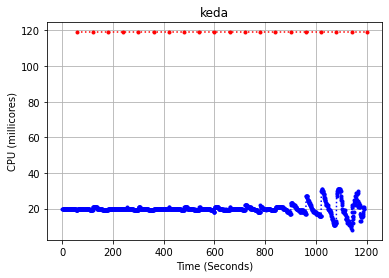

In [70]:
df2=pd.read_csv('time.csv')
df2['rps']= rps
time = df2['Time'].values
plt.plot(time[:-10],rps[:-10],linestyle='dotted', color='b', marker='.',label='cpu_used')
plt.plot(df['Time'],df['InvocationsPerMinute'],linestyle='dotted', color='r', marker='.',label='cpu_used')


#plt.plot(df['InvocationsPerMinute'], df['Time'], linestyle='dotted',  color='r', marker='.',label='cpu_requested')
plt.title('keda')
plt.xlabel('Time (Seconds)')
plt.ylabel('CPU (millicores)')

plt.grid()

[0. 0. 0. ... 0. 0. 0.]


In [72]:

# Run length encoding merges contiguous seconds with the same request rate
per_second_rates = rps
n = len(per_second_rates)
element_does_not_match_prev = per_second_rates[1:] != per_second_rates[:-1]
positions_where_element_does_not_match = np.append(np.where(element_does_not_match_prev), n - 1)  # noqa E501
#print(positions_where_element_does_not_match)

run_lengths = np.diff(np.append(-1, positions_where_element_does_not_match))
#print(run_lengths)
key_elements = per_second_rates[positions_where_element_does_not_match]
#print(key_elements)
pre_allocated_vus = int(np.ceil(np.max(per_second_rates) / 10))
start_rate = 0
if len(key_elements) > 0:
    start_rate = int(key_elements[0])

stage_list = []
for i in range(len(key_elements)):
    duration_in_seconds = int(run_lengths[i])
    target = int(key_elements[i])
    # Split longer stages than 1s to model sharp transitions
    # instead of linearly ramping up/down.
    # Skip splitting for first stage and use startRate instead.
    if duration_in_seconds > 1 and i > 0:
        stage_list.append({
            'users': target,
            'duration': 1,
            'spawn_rate': 1
        })
        stage_list.append({
            'users': target,
            'duration': int(duration_in_seconds - 1),
            'spawn_rate': target
        })
    else:
        stage_list.append({
            'users': target,
            'duration': int(duration_in_seconds),
            'spawn_rate': target
        })

# reference for this object:
# https://k6.io/docs/using-k6/scenarios/executors/ramping-arrival-rate
config_object = {
    'scenarios': {
        'benchmark_scenario': {
            'executor': 'ramping-arrival-rate',
            'startRate': start_rate,
            'timeUnit': '1s',
            'preAllocatedVUs': pre_allocated_vus,
            'stages': stage_list
        }
    }
}
print(stage_list)


[{'users': 20, 'duration': 54, 'spawn_rate': 20}, {'users': 19, 'duration': 1, 'spawn_rate': 1}, {'users': 19, 'duration': 5, 'spawn_rate': 19}, {'users': 20, 'duration': 1, 'spawn_rate': 1}, {'users': 20, 'duration': 46, 'spawn_rate': 20}, {'users': 19, 'duration': 1, 'spawn_rate': 1}, {'users': 19, 'duration': 12, 'spawn_rate': 19}, {'users': 21, 'duration': 1, 'spawn_rate': 1}, {'users': 21, 'duration': 16, 'spawn_rate': 21}, {'users': 20, 'duration': 1, 'spawn_rate': 1}, {'users': 20, 'duration': 19, 'spawn_rate': 20}, {'users': 19, 'duration': 1, 'spawn_rate': 1}, {'users': 19, 'duration': 22, 'spawn_rate': 19}, {'users': 20, 'duration': 1, 'spawn_rate': 1}, {'users': 20, 'duration': 74, 'spawn_rate': 20}, {'users': 21, 'duration': 1, 'spawn_rate': 21}, {'users': 20, 'duration': 1, 'spawn_rate': 1}, {'users': 20, 'duration': 23, 'spawn_rate': 20}, {'users': 19, 'duration': 1, 'spawn_rate': 1}, {'users': 19, 'duration': 19, 'spawn_rate': 19}, {'users': 21, 'duration': 1, 'spawn_rat

In [54]:
import json
json_data=[]
users=0
for i in range(len(stage_list)):
  if i==0:
    data =stage_list[i]
    json_data.append(data)
    print(json_data)
    pass

  else:   
   data =stage_list[i]
   p_data = stage_list[i-1]
   print(i,data['duration'],p_data['duration'])
   data['duration']=data['duration']+p_data['duration']
   json_data.append(data)
   users +=data['users']

[{'users': 0, 'duration': 540, 'spawn_rate': 0}]
1 1 540
2 59 541
3 1 600
4 59 601
5 1 660
6 111 661
7 1 772
8 7 773
9 1 780
10 59 781
11 1 840
12 136 841
13 1 977
14 42 978
15 1 1020
16 179 1021


In [73]:
print(json_data)

[{'users': 0, 'duration': 540, 'spawn_rate': 0}, {'users': 1, 'duration': 541, 'spawn_rate': 1}, {'users': 1, 'duration': 600, 'spawn_rate': 1}, {'users': 0, 'duration': 601, 'spawn_rate': 1}, {'users': 0, 'duration': 660, 'spawn_rate': 0}, {'users': 1, 'duration': 661, 'spawn_rate': 1}, {'users': 1, 'duration': 772, 'spawn_rate': 1}, {'users': 0, 'duration': 773, 'spawn_rate': 1}, {'users': 0, 'duration': 780, 'spawn_rate': 0}, {'users': 5, 'duration': 781, 'spawn_rate': 1}, {'users': 5, 'duration': 840, 'spawn_rate': 5}, {'users': 0, 'duration': 841, 'spawn_rate': 1}, {'users': 0, 'duration': 977, 'spawn_rate': 0}, {'users': 1, 'duration': 978, 'spawn_rate': 1}, {'users': 1, 'duration': 1020, 'spawn_rate': 1}, {'users': 0, 'duration': 1021, 'spawn_rate': 1}, {'users': 0, 'duration': 1200, 'spawn_rate': 0}]


In [52]:
users

16